In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate continuous feature s
num_samples = 100
s = torch.linspace(0, 10, num_samples).unsqueeze(1)

# Generate discrete feature a
a = torch.arange(4).repeat(num_samples // 4).unsqueeze(1)

# Concatenate s and a to form the input data (s, a)
train_x = torch.cat([s, a], dim=1)

# Generate output y (quadratic function with noise)
y = s.squeeze() ** 2 + torch.randn(num_samples) * 2

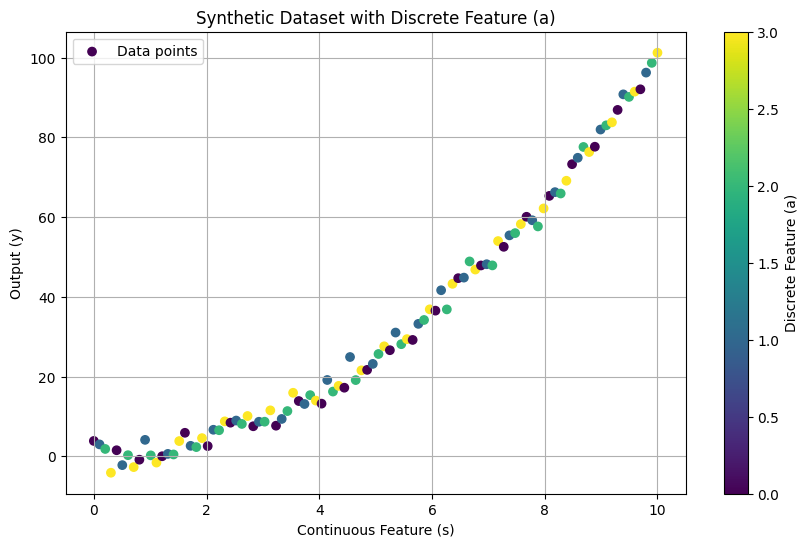

In [2]:
# Plot the dataset
plt.figure(figsize=(10, 6))
plt.scatter(s, y, c=a, cmap='viridis', label='Data points')
plt.xlabel('Continuous Feature (s)')
plt.ylabel('Output (y)')
plt.title('Synthetic Dataset with Discrete Feature (a)')
plt.colorbar(label='Discrete Feature (a)')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
# Convert the data into PyTorch tensors
train_x_tensor = train_x.float()
train_y_tensor = y.float()
train_x = train_x_tensor
train_y = train_y_tensor

print(train_x.shape)
print(train_y.shape)

# Create a TensorDataset
dataset = TensorDataset(train_x_tensor, train_y_tensor)

# Define batch size
batch_size = 32

# Create a DataLoader
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

torch.Size([100, 2])
torch.Size([100])


In [4]:
from gp.deepgp import DeepGPModel

# Define hidden layer configuration
hidden_layers_config = [
    {"output_dims": 10, "mean_type": "linear"},
    {"output_dims": None, "mean_type": "constant"}
]

# Instantiate the DeepGPModel
deep_gp_model = DeepGPModel(
    train_x_shape=train_x.shape,
    hidden_layers_config=hidden_layers_config,
    num_inducing_points=128,
    cat_dims=[1]  # Index of the discrete feature
)

In [5]:
import gpytorch
from gpytorch.mlls import DeepApproximateMLL

# Train the model
deep_gp_model.train()
deep_gp_model.likelihood.train()

optimizer = torch.optim.Adam(deep_gp_model.parameters(), lr=0.01)
mll = DeepApproximateMLL(gpytorch.mlls.VariationalELBO(deep_gp_model.likelihood, deep_gp_model, train_y.numel()))

training_iterations = 300
for i in range(training_iterations):
    optimizer.zero_grad()
    output = deep_gp_model(train_x)
    loss = -mll(output, train_y)
    print(loss.item())
    loss.backward()
    optimizer.step()

1473.0971432527267
1462.0470467064747
1451.121609963077
1440.2744568606088
1429.560904579878
1418.951705313314
1408.4451161586803
1398.0540026505894
1387.7818604378538
1377.621148225941
1367.5681408858104
1357.6263828854114
1347.8001737645147
1338.088536339019
1328.4883732064266
1318.997779202526
1309.6182795506043
1300.3514042699433
1291.1967201229377
1282.1512634710284
1273.2146778639337
1264.3863174780734
1255.6667313099197
1247.0552345372264
1238.5495936340405
1230.1487375382662
1221.8537813353912
1213.6604010759897
1205.5699332709191
1197.5822940815165
1189.6948205857348
1181.9031391349406
1174.211289619238
1166.6163054045835
1159.1192889125257
1151.705406183358
1144.4008710596186
1137.181834219966
1130.0493161144643
1122.992318474449
1116.046842989869
1109.1795864159617
1102.3841798732758
1095.6733247920718
1089.0351694694953
1082.4838255073787
1075.9937495251083
1069.5699963620589
1063.2783638256174
1056.9969958956685
1050.7928046542381
1044.6295591785772
1038.5722730810876
1032

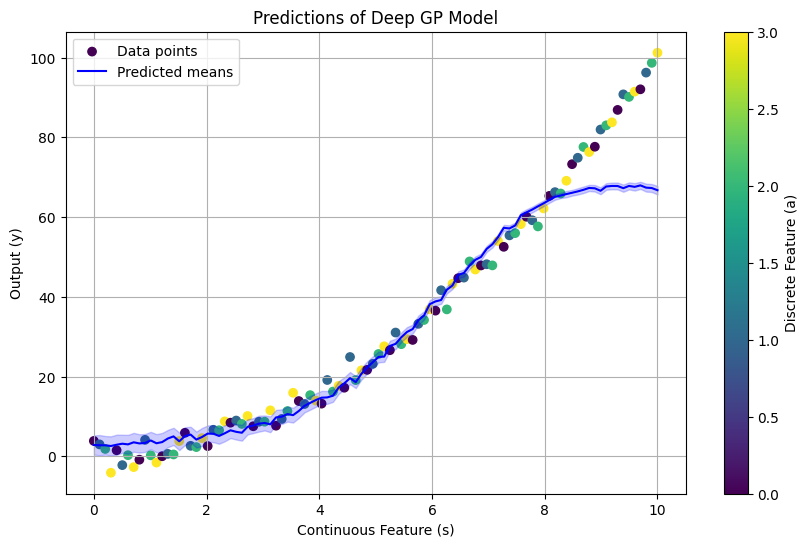

In [6]:
# Define a function to plot the predictions of the Deep GP model
def plot_predictions(model, loader):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Initialize lists to store predicted means and variances
        predicted_means = []
        predicted_variances = []

        # Predict on the input data
        for x_batch, _ in loader:
            preds = model.posterior(x_batch)
            predicted_means.append(preds.mean)
            predicted_variances.append(preds.variance)

        # Concatenate the predicted means and variances
        predicted_means = torch.cat(predicted_means, dim=0).cpu().numpy()
        predicted_variances = torch.cat(predicted_variances, dim=0).cpu().numpy()

    # Plot the original data points
    plt.figure(figsize=(10, 6))
    plt.scatter(train_x_tensor[:, 0].numpy(), train_y_tensor.numpy(), c=train_x_tensor[:, 1].numpy(),
                cmap='viridis', label='Data points')

    # Plot the predicted means
    plt.plot(train_x_tensor[:, 0].numpy(), predicted_means, color='blue', label='Predicted means')

    # Plot the predictive variance as shaded areas
    for i in range(predicted_means.shape[1]):
        plt.fill_between(train_x_tensor[:, 0].numpy(),
                         (predicted_means - 2 * predicted_variances ** 0.5)[:, i],
                         (predicted_means + 2 * predicted_variances ** 0.5)[:, i],
                         color='blue', alpha=0.2)

    # Set labels and title
    plt.xlabel('Continuous Feature (s)')
    plt.ylabel('Output (y)')
    plt.title('Predictions of Deep GP Model')
    plt.colorbar(label='Discrete Feature (a)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the predictions
plot_predictions(deep_gp_model, train_loader)